***
##### This module builds a Recurrent Neural Network (RNN) model with Long Short Term Memory (LSTM) architecture. The main task is to train a LSTM model to do stock price forecasting, and the forecasting is about the next-day stock price prediction

##### This module split the original data set into training set and test set. After training the LSTM model with the training set, the module computes the root mean square error (RMSE) and the coefficient of determination (R<sup>2</sup>) in the test set. Plus, the module computes the accuracy of trend prediction in the test set. In order to improve the data visualization, this module also plots the actual stock price and the predicted stock price on the same figure.
 
##### Authored by Menghong Huang and Zhaosheng Li.
***

## Importing python packages

In [1]:
%matplotlib inline
import numpy as np                # advanced math library
import matplotlib.pyplot as plt   # MATLAB like plotting routines
import pandas as pd               # For loading the data into dataframe
import matplotlib.dates as mdates # For converting the 'date' into numerical variable

# For calculating RMSE, the usage refers to https://stackoverflow.com/a/18623635 
from sklearn.metrics import mean_squared_error
from math import sqrt

# For splitting data set into training and test sets
from sklearn.model_selection import train_test_split
from math import ceil

# For calculating the coefficient of determination (R^2), 
# the usage refers to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
from sklearn.metrics import r2_score

# For applying normalization before feeding the data into the LSTM model
from sklearn.preprocessing import MinMaxScaler 

# Import some packages that will be used in modeling LSTM
import keras
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential

# For loading the trained model
from keras.models import load_model

## Load data into dataframe by using `panda` module

In [2]:
df = pd.read_csv("data/GME_stock.csv")

### Preserving the data into a datetime variable for later plotting

In [3]:
date = pd.to_datetime(df['date'])

### Reset the index of dataframe as 'date'

In [4]:
df.reset_index(inplace = True)
df.set_index("date", inplace = True)

In [5]:
df.head()

,index,open_price,high_price,low_price,close_price,volume,adjclose_price
date,,,,,,,
2002-02-13,0,9.625,10.060,9.525,10.050,19054000,6.766666
2002-02-14,1,10.175,10.195,9.925,10.000,2755400,6.733003
2002-02-15,2,10.000,10.025,9.850,9.950,2097400,6.699336
2002-02-19,3,9.900,9.900,9.375,9.550,1852600,6.430017
2002-02-20,4,9.600,9.875,9.525,9.875,1723200,6.648838


## Set the `close price` as label

In [6]:
close_price = df[['close_price']]

In [7]:
close_price.head()

,close_price
date,
2002-02-13,10.050
2002-02-14,10.000
2002-02-15,9.950
2002-02-19,9.550
2002-02-20,9.875


## Normalizing all the features and label to avoid overfitting

In [8]:
scaler = MinMaxScaler(feature_range = (0,1))

In [9]:
df_scaled = scaler.fit_transform(df.values)[:, 1:]
close_price = scaler.fit_transform(close_price.values)

## Initializing the time step for LSTM

In [10]:
time_steps = 4

## Loading all the features and label from dataframe to list

In [11]:
X = []
y = []
for index in range(time_steps, df_scaled.shape[0]):
    X.append(df_scaled[index - time_steps:index, :])
    y.append(close_price[index, :])

## Initializing the number of features for LSTM

In [12]:
features = X[0].shape[1]
features

6

## Splitting the dataset into training and test sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [14]:
split_date_index = time_steps - 1 + len(X_train)  # The 'date' splits the dataset into the two sets

dates_training = date[time_steps - 1:split_date_index]
dates_test = date[split_date_index:split_date_index + len(X_test)]

## Loading the trained LSTM model

In [18]:
model = load_model('LSTM_Model/LSTM_1_model.h5')

## Building the LSTM model

##### If you have already loaded the LSTM model in the `Load the trained LSTM model` section, please feel free to skip this step

In [19]:
model = Sequential()

model.add(LSTM(units = 64, return_sequences = True, input_shape = (time_steps, features)))
model.add(Dropout(0.2))
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 64))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.summary()
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 64)             18176     
_________________________________________________________________
dropout (Dropout)            (None, 4, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 64)             33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

## Training the LSTM model

##### If you have already loaded the LSTM model in the `Load the trained LSTM model` section, please feel free to skip this step

In [20]:
model.fit(np.array(X_train), np.array(y_train), epochs = 100)

Epoch 1/100
120/120 [==============================] - 9s 10ms/step - loss: 9.8576e-04
Epoch 2/100
120/120 [==============================] - 1s 9ms/step - loss: 5.9761e-05
Epoch 3/100
120/120 [==============================] - 1s 10ms/step - loss: 4.9051e-05: 0s 
Epoch 4/100
120/120 [==============================] - 1s 10ms/step - loss: 4.1377e-05
Epoch 5/100
120/120 [==============================] - 1s 11ms/step - loss: 3.4282e-05
Epoch 6/100
120/120 [==============================] - 1s 10ms/step - loss: 3.8607e-05
Epoch 7/100
120/120 [==============================] - 1s 10ms/step - loss: 3.6535e-05
Epoch 8/100
120/120 [==============================] - 1s 11ms/step - loss: 3.1503e-05
Epoch 9/100
120/120 [==============================] - 1s 12ms/step - loss: 2.8928e-05
Epoch 10/100
120/120 [==============================] - 1s 11ms/step - loss: 3.0316e-05
Epoch 11/100
120/120 [==============================] - 1s 11ms/step - loss: 2.9833e-05
Epoch 12/100
120/120 [===============

## Save the trained LSTM model

##### If you have already loaded the LSTM model in the `Load the trained LSTM model` section, please feel free to skip this step

In [32]:
# Save the trained LSTM model
model.save('LSTM_Model/LSTM_1_model.h5')

## Plotting the actual price and predicted price in the training set

### Denormalizing the training data

In [19]:
train_predicted_value = scaler.inverse_transform(model.predict(np.array(X_train)))
train_actual_value = scaler.inverse_transform(np.array(y_train))

### Making the plot

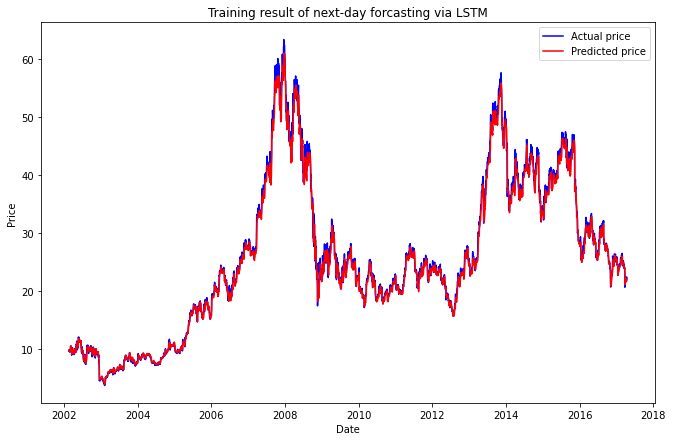

In [42]:
plt.figure(figsize = (11, 7))
plt.plot(dates_training, train_actual_value, color= 'blue', label= 'Actual price')
plt.plot(dates_training, train_predicted_value, color= 'red', label= 'Predicted price') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Training result of next-day forcasting via LSTM')
plt.legend()
plt.savefig('img/LSTM_1_training_result.png')
plt.show()

## Plotting the actual price and predicted price in the test set

### Denormalizing the test data

In [38]:
test_predicted_value = scaler.inverse_transform(model.predict(np.array(X_test)))
test_actual_value = scaler.inverse_transform(np.array(y_test))

### Making the plot

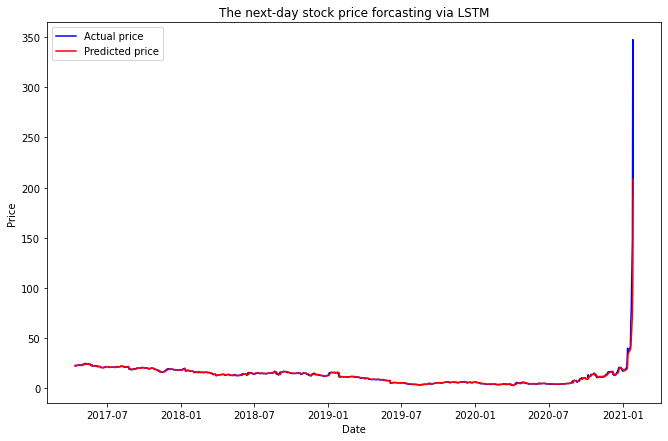

In [39]:
plt.figure(figsize = (11, 7))
plt.plot(dates_test, test_actual_value, color= 'blue', label= 'Actual price')
plt.plot(dates_test, test_predicted_value, color= 'red', label= 'Predicted price') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('The next-day stock price forcasting via LSTM')
plt.legend()
plt.savefig('img/LSTM_1_test_result.png')
plt.show()

### Computing the root mean square error (RMSE)

In [40]:
RMSE = sqrt(mean_squared_error(test_actual_value, test_predicted_value))
print(f'The root mean square error (RMSE) for the LSTM model is {RMSE}')

The root mean square error (RMSE) for the LSTM model is 8.406693832928928


### Computing the coefficient of determination (R<sup>2</sup>)

In [41]:
R_2 = r2_score(test_actual_value, test_predicted_value)
print(f'The coefficient of determination (R^2) for the LSTM model is {R_2}')

The coefficient of determination (R^2) for the LSTM model is 0.6783714024188348


### Building a function to compute the trend prediction accuracy

In [25]:
def accForTrendPredict(test_actual_value, test_predicted_value):
    y_var_test = test_actual_value[1:] - test_actual_value[:len(test_actual_value)-1]
    y_var_predict = test_predicted_value[1:] - test_predicted_value[:len(test_predicted_value)-1]

    return (np.sum(np.sign(y_var_test) == np.sign(y_var_predict)) / len(y_var_test)) * 100

### Computing the accuracy of trend prediction

In [26]:
acc_trend_prediction = accForTrendPredict(test_actual_value, test_predicted_value)
print(f'The accuracy of trend prediction is {acc_trend_prediction}%')

The accuracy of trend prediction is 49.84260230849947%


## Removing the last 11 days

### Denormalizing the test data without the last 11 days

In [27]:
test_predicted_value = scaler.inverse_transform(model.predict(np.array(X_test[:-11])))
test_actual_value = scaler.inverse_transform(np.array(y_test[:-11]))

### Making the plot

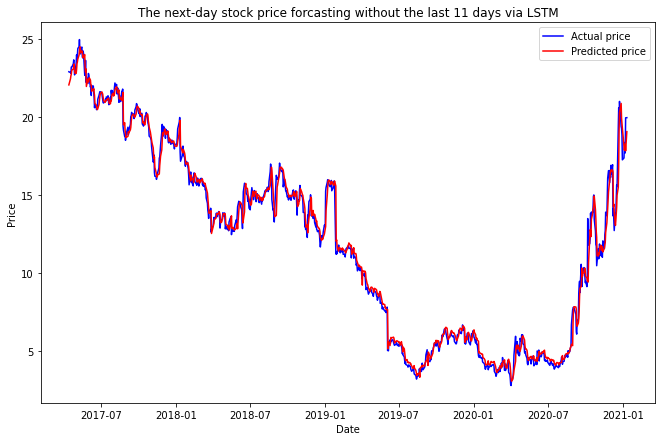

In [34]:
plt.figure(figsize = (11, 7))
plt.plot(dates_test[:-11], test_actual_value, color= 'blue', label= 'Actual price')
plt.plot(dates_test[:-11], test_predicted_value, color= 'red', label= 'Predicted price') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('The next-day stock price forcasting without the last 11 days via LSTM')
plt.legend()
plt.savefig('img/LSTM_1_without_last_11_days.png')
plt.show()

### Computing the root mean square error (RMSE)

In [35]:
RMSE = sqrt(mean_squared_error(test_actual_value, test_predicted_value))
print(f'The root mean square error (RMSE) for the LSTM model is {RMSE}')

The root mean square error (RMSE) for the LSTM model is 0.5827112729880608


### Computing the coefficient of determination (R<sup>2</sup>)

In [36]:
R_2 = r2_score(test_actual_value, test_predicted_value)
print(f'The coefficient of determination (R^2) for the LSTM model is {R_2}')

The coefficient of determination (R^2) for the LSTM model is 0.9909084524227111


### Computing the accuracy of trend prediction

In [37]:
acc_trend_prediction = accForTrendPredict(test_actual_value, test_predicted_value)
print(f'The accuracy of trend prediction is {acc_trend_prediction}%')

The accuracy of trend prediction is 49.575371549893845%
